# Activation function engineering
In this notebook, we perform gradient descent in the space of activation functions to find a parameterized $\hat{\phi}$ that mimics the kernel of a 4HL ReLU net.



# Imports and installs

In [ ]:
!pip install -q git+https://www.github.com/google/neural-tangents

import os
import sys

!git clone -q https://github.com/james-simon/eigenlearning.git
sys.path.insert(0,'/content/eigenlearning')

     |████████████████████████████████| 99 kB 3.8 MB/s 


In [ ]:
import time

import jax
import jax.random as random
import jax.numpy as np
import numpy as basenp

import matplotlib.pyplot as plt

import neural_tangents as nt

import utils, measures

from scipy.optimize import minimize
import time

/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)


In [ ]:
key = jax.random.PRNGKey(17)

# Helpers

Squared error is the metric we use to compare the empirical and target kernels.

In [ ]:
def squared_error(K_phi, K_target, exclude_endpoints=True):
  if exclude_endpoints:
    exact = K_target[10:-10]
    empirical = K_phi[10:-10]
  else:
    exact = K_target
    empirical = K_phi
  
  error = (exact - empirical)
  return np.sum(error**2)

In [ ]:
def fcut(x, a=3):
  return ('{:.'+str(a)+'f}').format(x)

In [ ]:
def unit_circle_samples(n, cosine_spaced=False):
  if cosine_spaced:
    cosines = np.linspace(1, -1, n)
    sines = (1 - cosines**2)**.5
    X = np.stack([cosines, sines]).T * 2**.5
    thetas = np.arccos(cosines)
  
  else:
    thetas = np.linspace(0, np.pi, n)
    cosines = np.cos(thetas)
    sines = np.sin(thetas)
    X = np.stack([cosines, sines]).T * 2**.5

  return X, thetas

We evaluate kernels values between -1 and 1 or on angles between 0 and $\pi$.

In [ ]:
X, thetas = unit_circle_samples(100)

In [ ]:
def kernel_curve(phi, W_std=1, b_std=0, num_hidden=1, width=2**14):
  net_fns = utils.get_net_fns(width, 1, n_hidden_layers=num_hidden, W_std=W_std, b_std=b_std, phi=phi)

  global key
  key, subkey = random.split(key)
  _, params = net_fns[0](subkey, (-1,2))
  kernel_fn = nt.empirical_kernel_fn(net_fns[1])
  return(kernel_fn(X, X[:1], 'ntk', params)[:,0])

In [ ]:
def average_kernel_curve(iters, phi, W_std=1, b_std=0, num_hidden=1, width=2**14):
  assert iters > 0
  kernel_data = []
  for i in range(iters):
    kernel_data.append(kernel_curve(phi, W_std, b_std, num_hidden, width))
  kernel_data = np.row_stack(kernel_data)
  average_kernel = np.mean(kernel_data, axis=0)
  std_kernel = np.std(kernel_data, axis=0)
  return average_kernel, std_kernel

Our target kernel (the one we wish to realize with a shallow, finite width network) is a 4HL ReLU NTK.

In [ ]:
_, _, target_kernel_fn = utils.get_net_fns(1, 1, n_hidden_layers=4, W_std=2**.5, b_std=0.1, phi='relu')

K_target = target_kernel_fn(X, X[:1], 'ntk')[:,0]

# Plot kernels

We optimize $\tilde{\phi}$ with 7 free parameters. The values below are a guess for the parameters made by hand. To reduce variance from network intialization, we average the kernels over 100 realizations.

In [ ]:
a, b, c, d, e, f, g = 3.5, 1, .05, .8, .1, 10, np.pi/4+.1
phi = lambda z : a*jax.nn.relu(z - b) + c*z + d + e*np.cos(f*z + g)


K_phi_avg, K_phi_std = average_kernel_curve(100, phi, width=2**10)
K_4HL_avg, K_4HL_std = average_kernel_curve(100, 'relu', W_std=2**0.5, b_std=0.1, num_hidden=4, width=2**10)

/usr/local/lib/python3.7/dist-packages/neural_tangents/_src/stax/elementwise.py:804: UserWarning: Numerical Activation Layer with fn=<function <lambda> at 0x7f85251165f0>, deg=40 used!Note that numerical error is controlled by `deg` and for a giventolerance level, required `deg` will highly be dependent on the choiceof `fn`.
  f'Numerical Activation Layer with fn={fn}, deg={deg} used!'
/usr/local/lib/python3.7/dist-packages/neural_tangents/_src/stax/elementwise.py:813: UserWarning: Using JAX autodiff to compute the `fn` derivative for NTK. Beware of https://jax.readthedocs.io/en/latest/faq.html#gradients-contain-nan-where-using-where.
  'Using JAX autodiff to compute the `fn` derivative for NTK. Beware of '


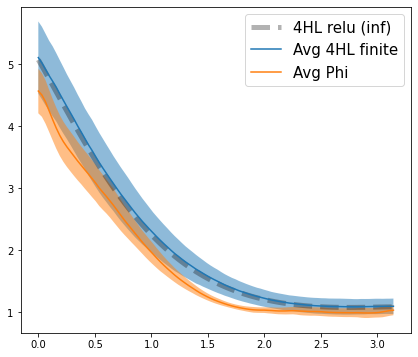

In [ ]:
fig, ax = plt.subplots(figsize=(7,6))

ax.plot(thetas, K_target, label='4HL relu (inf)', color=(0,0,0,.3), linestyle='dashed', lw=5)
ax.plot(thetas, K_4HL_avg, label='Avg 4HL finite')
ax.fill_between(thetas, K_4HL_avg + K_4HL_std, K_4HL_avg - K_4HL_std, alpha=0.5)
ax.plot(thetas, K_phi_avg, label='Avg Phi')
ax.fill_between(thetas, K_phi_avg + K_phi_std, K_phi_avg - K_phi_std, alpha=0.5)

ax.legend(fontsize=15)

# Optimize Kernels
We want to optimize the activation function to achieve a kernel closes to the desired, infinite width target ReLU NTK. We measure closeness by squared error, $\sum \left(K_\text{target} - K_\text{empirical}\right)^2$. We average the empirical kernel over 100 initializations of the net so that the error measure between target and empirical is more consistent.

In [ ]:
def define_phi_7(phi_coeffs):
  a, b, c, d, e, f, g = phi_coeffs
  phi = lambda z : a*jax.nn.relu(z - b) + c*z + d + e*np.cos(f*z + g)
  return phi

def define_phi_9(phi_coeffs):
  a, b, c, d, e, f, g, h, i = phi_coeffs
  phi = lambda z : a*jax.nn.relu(z - b) + c*jax.nn.relu(z - d) + e*z + f + g*np.cos(h*z + i)
  return phi

def define_phi(phi_coeffs):
  if len(phi_coeffs) == 7:
    phi = define_phi_7(phi_coeffs)
  else:
    phi = define_phi_9(phi_coeffs)
  return phi
  
def phi_coeff_fitness_function(phi_coeffs):
  phi = define_phi(phi_coeffs)
  rse = squared_error(average_kernel_curve(20, phi)[0], K_target, False)
  return rse

To define an initial simplex for Nelder-Mead, we use the standard initialization algorithm implemented in Matlab.

In [ ]:
def random_coeffs(dim=9):
  return [basenp.random.rand()*1 for _ in range(dim)]

def initial_simplex(phi_coeffs):
  N = len(phi_coeffs)
  simplex = basenp.zeros((N+1, N))
  simplex[0,:] = phi_coeffs
  for i in range(N):
    simplex[i+1,:] = phi_coeffs + basenp.eye(1, N, i) * (0.5 * basenp.max([phi_coeffs[i], 1]))
  return simplex

## Starting from by-hand parameters

This takes a long time (2 hours or more) to run, even using a GPU.

In [ ]:
phi_coeffs_guess = a, b, c, d, e, f, g

options = {'disp': True, 'initial_simplex': initial_simplex(phi_coeffs_guess), 'maxiter': 1000}

t1 = time.time()
result = minimize(phi_coeff_fitness_function,
                  x0=phi_coeffs_guess,
                  method='Nelder-Mead',
                  tol=1.e-2,
                  options=options)
t2 = time.time()
print('Optimization time:', t2 - t1)

print('Final Params:', list(result.x), squared_error(average_kernel_curve(10, define_phi(list(result.x)))[0], K_target, False))

In [ ]:
phi_coeffs_optimized = list(result.x)
phi_opt = define_phi(phi_coeffs_optimized)
K_phi_opt_avg, K_phi_opt_std = average_kernel_curve(100, phi_opt)

fig, ax = plt.subplots(figsize=(7,6))

ax.plot(thetas, K_target, label='4HL relu (inf)', color=(0,0,0,.3), linestyle='dashed', lw=5)
ax.plot(thetas, K_phi_opt_avg, label='Avg Phi Opt')
ax.fill_between(thetas, K_phi_opt_avg + K_phi_opt_std, K_phi_opt_avg - K_phi_opt_std, alpha=0.5)
ax.plot(thetas, K_phi_avg, label='Avg Phi')
ax.fill_between(thetas, K_phi_avg + K_phi_std, K_phi_avg - K_phi_std, alpha=0.5)

ax.legend(fontsize=15)

# Comparing Optimized and 4HL Finite

/usr/local/lib/python3.7/dist-packages/neural_tangents/_src/stax/elementwise.py:804: UserWarning: Numerical Activation Layer with fn=<function define_phi_7.<locals>.<lambda> at 0x7f85251ddf80>, deg=40 used!Note that numerical error is controlled by `deg` and for a giventolerance level, required `deg` will highly be dependent on the choiceof `fn`.
  f'Numerical Activation Layer with fn={fn}, deg={deg} used!'
/usr/local/lib/python3.7/dist-packages/neural_tangents/_src/stax/elementwise.py:813: UserWarning: Using JAX autodiff to compute the `fn` derivative for NTK. Beware of https://jax.readthedocs.io/en/latest/faq.html#gradients-contain-nan-where-using-where.
  'Using JAX autodiff to compute the `fn` derivative for NTK. Beware of '


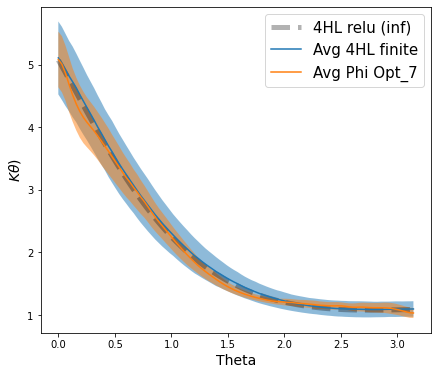

In [ ]:
# Function used in mimic 4HL ReLU experiments.
chosen_phi_coeffs_optimized_7 = [3.8001579818118927, 1.0600013769145225, 0.09680930566346302, 0.9010060417094072, -0.07936104642025432, 11.810565331593281, 0.9340552512015492]
chosen_phi_opt_7 = define_phi(chosen_phi_coeffs_optimized_7)

K_chosen_phi_opt_avg_7, K_chosen_phi_opt_std_7 = average_kernel_curve(100, chosen_phi_opt_7, width=2**10)

fig, ax = plt.subplots(figsize=(7,6))

ax.plot(thetas, K_target, label='4HL relu (inf)', color=(0,0,0,.3), linestyle='dashed', lw=5)
ax.plot(thetas, K_4HL_avg, label='Avg 4HL finite')
ax.fill_between(thetas, K_4HL_avg + K_4HL_std, K_4HL_avg - K_4HL_std, alpha=0.5)
ax.plot(thetas, K_chosen_phi_opt_avg_7, label='Avg Phi Opt_7')
ax.fill_between(thetas, K_chosen_phi_opt_avg_7 + K_chosen_phi_opt_std_7, K_chosen_phi_opt_avg_7 - K_chosen_phi_opt_std_7, alpha=0.5)

ax.set_xlabel('Theta', fontsize=14)
ax.set_ylabel(r'$K\theta)$', fontsize=14)

ax.legend(fontsize=15)